In [1]:
# milostipanov@gmail.com 
# https://github.com/meteorids
# 2022

#This Code is to process the output from the NeuralNetwork-Predict. Creating plots and statistics. Will combine the output file from the NN and the NILU-data-process for time stamps.

In [2]:
#This block reads the daily data from NN-output and NILU-data-process output.

import pandas as pd
import numpy as np
import math
from datetime import datetime
# Seting up data:

namestring = '_all_year'

df_nilu = pd.DataFrame()
for year in range(2014,2020):
    measurement_year = str(year)
    processed_data = pd.read_csv('../MachineLearning-NILU/nnoutput_'+measurement_year+'.txt',  sep=r'\s+', header=None)
    timestamp     = pd.read_csv('./NILU-OUT/processed_nilu_'+measurement_year+'.txt',  sep=r'\s+', header=None)

    #year = str(timestamp[1])
    date_nilu = timestamp[3]
    time_nilu = timestamp[5]
    doy_nilu  = timestamp[4]
    sza_nilu  = timestamp[0]
    scaled_ozone_nilu   = processed_data[0]
    vol_frac_nilu       = processed_data[1]*10**-7

    # Converting scaled ozone to Dobson Units
    # Scaled to standard US atmosphere, the equivalent depth of ozone is 3.45×10^−3 m, in Dobson units= 345 DU. 1 eqd = 10^5 DU
    ozone_DU_nilu = scaled_ozone_nilu*345
    # Converting cloud particle vol. frac. to COD. Based on simulations. see code: COD_vs_volfrac.ipynb
    cod_nilu = vol_frac_nilu*152596238.214


    df = pd.DataFrame({'DATE_NILU': date_nilu,
                   'TIMEUTC_NILU': time_nilu,
                    'DOY_NILU': doy_nilu,
                   'SZA_NILU': sza_nilu,
                   'O3_NILU': ozone_DU_nilu,
                   'COD_NILU': cod_nilu})
    df_nilu = pd.concat([df_nilu, df])

df_nilu = df_nilu.reset_index()
print(df_nilu)
df_nilu.to_csv("./STATS-PLOTS-OUT/dataframe.csv")
mylambda1 = lambda x: math.cos(math.radians(x))
df_nilu['SZA_COS_NILU'] = df_nilu['SZA_NILU'].apply(mylambda1)
df_nilu['COD_NILU_CORR'] = df_nilu['COD_NILU']/df_nilu['SZA_COS_NILU']

high_noons = df_nilu.loc[df_nilu.groupby('DOY_NILU').SZA_NILU.idxmin()].reset_index()

# creating a lambda function, to filter out the outliners
mylambda2 = lambda x: x if x > 200 else np.nan
high_noons['O3_NILU'] = high_noons['O3_NILU'].apply(mylambda2)

#daily means:
ozone_daily_mean_nilu = df_nilu.groupby('DATE_NILU').O3_NILU.mean().reset_index()
ozone_daily_mean_nilu.rename(columns = {'DATE_NILU':'DATE'}, inplace = True)

cod_daily_mean_nilu = df_nilu.groupby('DATE_NILU').COD_NILU.mean().reset_index()
#doy_nilu = df_nilu.groupby('DOY_NILU').mean().reset_index()
ozone_daily_mean_nilu['COD'] = cod_daily_mean_nilu['COD_NILU'] 
ozone_daily_mean_nilu['DATE'] = ozone_daily_mean_nilu['DATE'].astype(str)

#print(cod_daily_mean_nilu)
print(ozone_daily_mean_nilu)
print(type(ozone_daily_mean_nilu))


          index  DATE_NILU  TIMEUTC_NILU  DOY_NILU  SZA_NILU     O3_NILU  \
0             0   20140101          1455         1    69.953  282.436448   
1             1   20140101          1456         1    69.857  283.228482   
2             2   20140101          1457         1    69.762  284.583437   
3             3   20140101          1458         1    69.668  285.672363   
4             4   20140101          1459         1    69.574  286.715696   
...         ...        ...           ...       ...       ...         ...   
1748942  110395   20190730          2215       211    69.227  196.274941   
1748943  110396   20190730          2216       211    69.415  212.129888   
1748944  110397   20190730          2217       211    69.602  200.130448   
1748945  110398   20190730          2218       211    69.790  200.811479   
1748946  110399   20190730          2219       211    69.978  203.331851   

         COD_NILU  
0        3.296148  
1        3.153004  
2        2.855082  
3      

In [3]:
#Reads OMI data
df_omi = pd.DataFrame()
for year in range(2014,2020):
    measurement_year = str(year)
    df = pd.read_csv('./OMI-dataprocess-output/omi_'+measurement_year+'.csv',  sep=r',', header=0)

 #   year_omi = df_omi['YEAR']
 #   month_omi = df_omi['MONTH']
 #   day_omi = df_omi['DAY']
 #   doy_omi = df_omi['DOY']
 #   ozone_daily_mean_omi = df_omi['OMI_O3']
    
#    df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']]).assign(DAY=1)
    df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']], format='%Y%m%d' ) 
#    df['DATE'] = df['DATE'].strftime(format='%Y%m%d')
    df_omi = pd.concat([df_omi, df])

df_omi = df_omi.reset_index()
df_omi['DATE'] = df_omi['DATE'].apply(lambda x: datetime.strftime(x, '%Y%m%d'))
df_omi['DATE'] = df_omi['DATE'].astype(str)
#all_data['Order Day new'] = all_data['Order Day new'].dt.strftime('%Y-%m-%d')

print(df_omi)
print(type(df_omi))

      index  Unnamed: 0  YEAR  MONTH  DAY  DOY      OMI_O3      DATE
0         0           0  2014      1    1    1  342.000000  20140101
1         1           1  2014      1    2    2  302.000000  20140102
2         2           2  2014      1    3    3  345.399994  20140103
3         3           3  2014      1    4    4         NaN  20140104
4         4           4  2014      1    5    5  307.000000  20140105
...     ...         ...   ...    ...  ...  ...         ...       ...
2167    360         360  2019     12   27  361         NaN  20191227
2168    361         361  2019     12   28  362  318.299988  20191228
2169    362         362  2019     12   29  363         NaN  20191229
2170    363         363  2019     12   30  364  305.500000  20191230
2171    364         364  2019     12   31  365         NaN  20191231

[2172 rows x 8 columns]
<class 'pandas.core.frame.DataFrame'>


In [28]:
#creating realtiv diff dataframe to merge OMI and NILU O3 data (if both exist) and calcule absolute and relative differance

from sklearn.linear_model import LinearRegression

diff = pd.merge(df_omi, ozone_daily_mean_nilu, on='DATE')
index_names = diff[ (diff['OMI_O3'].isnull() ) | (diff['O3_NILU'].isnull() )].index
print(type(index_names))
diff.drop(index_names, inplace = True)
diff['Absolute_diff'] = (diff['OMI_O3']-diff['O3_NILU']).abs()
diff['Relative_diff'] = diff['Absolute_diff'] / (diff['OMI_O3'] + diff['O3_NILU'])
print(diff)

#separating the data based on COD: 5 > COD; 10 > COD > 5 ....
diff_5 = diff.loc[(diff['COD'] < 5)].reset_index()
diff_5_10 = diff.loc[(diff['COD'] > 5 ) & ( diff['COD'] < 10 )].reset_index()
diff_10_20 = diff.loc[(diff['COD'] > 10 ) & ( diff['COD'] < 20 )].reset_index()
diff_20 = diff.loc[(diff['COD'] > 20)].reset_index()

rel_diff_5 = diff_5['Relative_diff'].mean()
rel_diff_5_10 = diff_5_10['Relative_diff'].mean()
rel_diff_10_20 = diff_10_20['Relative_diff'].mean()
rel_diff_20 = diff_20['Relative_diff'].mean()

print('Mean relative difference for COD < 5 : '+str(rel_diff_5))
print('Mean relative difference for 10 < COD < 5 : '+str(rel_diff_5_10))
print('Mean relative difference for 10 < COD < 20 : '+str(rel_diff_10_20))
print('Mean relative difference for 20 < COD  : '+str(rel_diff_20))

model = LinearRegression()
X = diff_5['COD'].values.reshape(-1,1)
Y = diff_5['Relative_diff'].values.reshape(-1,1)
model.fit(X,Y)
r_sq = model.score(X, Y)
print('R^2 : '+str(r_sq) )

<class 'pandas.core.indexes.numeric.Int64Index'>
      index  Unnamed: 0  YEAR  MONTH  DAY  DOY      OMI_O3      DATE  \
0         0           0  2014      1    1    1  342.000000  20140101   
1         1           1  2014      1    2    2  302.000000  20140102   
2         2           2  2014      1    3    3  345.399994  20140103   
4         4           4  2014      1    5    5  307.000000  20140105   
6         6           6  2014      1    7    7  358.899994  20140107   
...     ...         ...   ...    ...  ...  ...         ...       ...   
1563    206         206  2019      7   26  207  334.299988  20190726   
1564    207         207  2019      7   27  208  328.299988  20190727   
1565    208         208  2019      7   28  209  301.399994  20190728   
1566    209         209  2019      7   29  210  324.500000  20190729   
1567    210         210  2019      7   30  211  303.399994  20190730   

         O3_NILU        COD  Absolute_diff  Relative_diff  
0     298.391888   3.72775

In [ ]:
#Plotting daily average ozone concentration (NILU,OMI)
#%matplotlib inline
import matplotlib.pyplot as plt
plt.subplots(tight_layout=True)
plt.scatter(df_omi['DOY'], df_omi['OMI_O3'], marker='.', color='grey')
plt.scatter(ozone_daily_mean_nilu['DOY'], ozone_daily_mean_nilu['O3_NILU'], marker='+', color='black')
plt.xlabel('Day of the year')
plt.ylabel('Total Ozone Column  [DU]')
plt.legend(['OMI','NILU'])

plt.savefig('OMI_L3_NILU_O3_'+namestringr+'.pdf',dpi = 300)
plt.show()
        

In [ ]:
#Plotting absolute differance between NILU and OMI data, calculating STD for NILU and OMI yearly data

#absolute_differance = (abs(df_omi['OMI_O3']-high_noons['O3_NILU']))
yearly_mean_absolute_difference = diff['Absolute_diff'].mean()
std_nilu = high_noons['O3_NILU'].std()
std_omi = df_omi['OMI_O3'].std()
print("Yearly mean absolute difference: " ,yearly_mean_absolute_difference)
print("Yearly O3 standard deviation for NILU data: ",std_nilu)
print("Yearly O3 standard deviation for OMI data: ",std_omi)

plt.scatter(diff['DOY'], diff['Absolute_diff'], marker='.', color='black')
plt.xlabel('Day of the year')
plt.ylabel('Absolute O3 differance')
plt.savefig('OMI_NILU_O3_abs_diff_'+namestring+'.pdf')
plt.show()

Yearly mean relative difference:  0.03242167156743927
Yearly O3 standard deviation for NILU data:  51.3163830465507


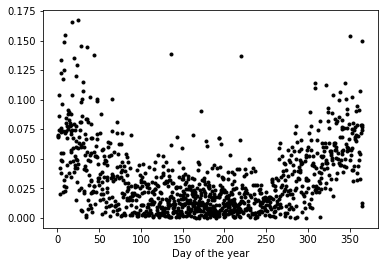

In [7]:
#Plotting relative differance between NILU and OMI data
import math

yearly_mean_relative_difference = diff['Relative_diff'].mean()
std_nilu = high_noons['O3_NILU'].std()
print("Yearly mean relative difference: " ,yearly_mean_relative_difference)
print("Yearly O3 standard deviation for NILU data: ",std_nilu)

plt.scatter(diff['DOY'], diff['Relative_diff'], marker='.', color='black')
plt.xlabel('Day of the year')
plt.savefig('OMI_NILU_O3_rel_diff_'+namestring+'.pdf')
plt.show()

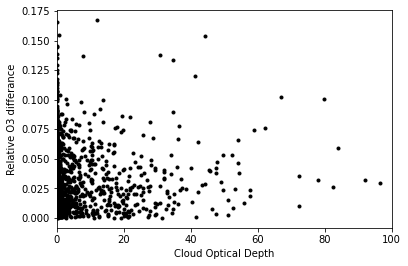

In [8]:
#plot COD vs relative difference

plt.scatter(diff['COD'], diff['Relative_diff'], marker='.', color='black')
plt.ylabel('Relative O3 differance')
plt.xlabel('Cloud Optical Depth')
plt.xlim([0, 100])
plt.savefig('COD_vs_OMI_NILU_O3_rel_diff_'+namestring+'.pdf')
plt.show()

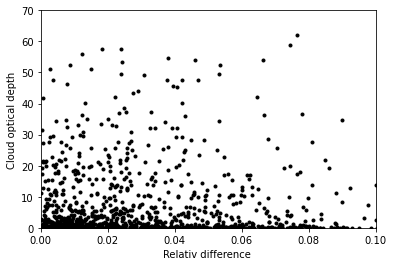

In [9]:
#plot relativ difference vs COD

plt.ylabel('Cloud optical depth')
plt.xlabel('Relativ difference ')
plt.scatter(diff['Relative_diff'], diff['COD'] , marker='.', color='black')
plt.ylim([0, 70])
plt.xlim([0, 0.1])
plt.savefig('Rel_diff_vs_COD_'+namestring+'.pdf')
plt.show()

KeyError: 'DOY_NILU'

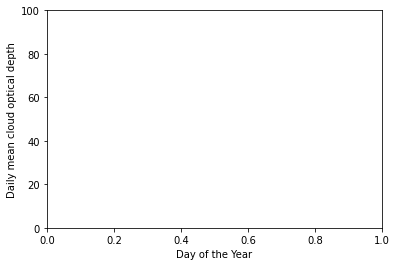

In [10]:
#Plotting cloud optical depth (predicted from NN) vs DOY
#print(cod_daily_mean_nilu)
#print(relative_differance)
plt.ylabel('Daily mean cloud optical depth')
plt.xlabel('Day of the Year')
plt.ylim([0, 100])
#plt.xlim([0, 50])
plt.scatter(cod_daily_mean_nilu['DOY_NILU'], cod_daily_mean_nilu['COD_NILU'], marker='.', color='black')
plt.savefig('COD_vs_DOY_'+namestring+'.pdf')
plt.show()